In [1]:
import pandas as pd
import numpy as np
import pickle
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from matplotlib import pyplot as plt

In [2]:
with open('players.pkl', 'rb') as f:
    data_players = pickle.load(f)
    
with open('results.pkl', 'rb') as f:
    data_results = pickle.load(f)
    
with open('tournaments.pkl', 'rb') as f:
    data_tournaments = pickle.load(f)

In [3]:
data_players[2935]

{'id': 2935,
 'name': 'Анатолий',
 'patronymic': 'Рафаилович',
 'surname': 'Белкин'}

### 1. Подготовка данных для моделей.

Сначала извлечем из данных наборы трейна и теста. Вероятно, стоило работать с данными через pandas, но мне это пришло в голову поздно и не хотелось переделывать. 

Возьмем турниры с результатами и из нужных годов.

In [4]:
tourn_train = []
tourn_test = []
for idx in data_results.keys():
    if data_results[idx] != [] and 'mask' in data_results[idx][0].keys() and data_results[idx][0]['mask'] is not None:
        if data_tournaments[idx]['dateStart'][0:4] == '2019':
            tourn_train.append(idx)
        if data_tournaments[idx]['dateStart'][0:4] == '2020':
            tourn_test.append(idx)           
    
print("Number of tournaments in train =", len(tourn_train))
print("Number of tournaments in test =", len(tourn_test))

Number of tournaments in train = 674
Number of tournaments in test = 173


Теперь избавимся от тех турниров, где разные команды играют разное число вопросов, есть команды без данных о результате или членах команды или всего одна команда.

In [5]:
def get_inconsistent_tourn(list_of_tournaments):

    counter_inconsistent = 0
    inconsistent_tourn_list = []
    
    for idx_tourn in list_of_tournaments:
        
        inconsistent_tourn = False

        num_of_current_questions = len([int(res) for res in data_results[idx_tourn][0]['mask'] if res=='0' or res=='1'])
        
        idx_teams = 0
        while idx_teams < len(data_results[idx_tourn]) and inconsistent_tourn == False:
            
            if data_results[idx_tourn][idx_teams]['mask'] is None:
                #print("in tourn ", idx_tourn, " team ", idx_teams, "has no result")
                inconsistent_tourn = True
            elif len(data_results[idx_tourn]) == 1:
                #print("only one team here!")
                inconsistent_tourn = True
            elif data_results[idx_tourn][idx_teams]['teamMembers'] == []:
                #print("in tourn ", idx_tourn, " team ", idx_teams, "has no team members")
                inconsistent_tourn = True              
                
                
            if data_results[idx_tourn][idx_teams]['mask'] is not None and len(
                        [int(res) for res in data_results[idx_tourn][idx_teams]['mask'] if res=='0' or res=='1']
                                                                                ) != num_of_current_questions:
                #print("in tourn ", idx_tourn, "different amount of questions!")
                inconsistent_tourn = True
                #print("Alarm! extra questions!", len(data_results[idx_tourn][idx_teams]['mask']) - num_of_current_questions)
            
            idx_teams += 1
            
        if inconsistent_tourn == True:
            counter_inconsistent += 1
            inconsistent_tourn_list.append(idx_tourn)
            #print("Tournament with idx ", idx_tourn, " is inconsistent")
                             
    print("number of inconsistent tournaments =", counter_inconsistent)

    return inconsistent_tourn_list

In [6]:
inconsistent_tourn_train = get_inconsistent_tourn(tourn_train)
inconsistent_tourn_test = get_inconsistent_tourn(tourn_test)

number of inconsistent tournaments = 38
number of inconsistent tournaments = 17


In [7]:
tourn_train = [t for t in tourn_train if t not in inconsistent_tourn_train]
tourn_test = [t for t in tourn_test if t not in inconsistent_tourn_test]

print("Now number of tournaments in train =", len(tourn_train))
print("Now number of tournaments in test =", len(tourn_test))

Now number of tournaments in train = 636
Now number of tournaments in test = 156


Приготовим данные для one-hot encoding: соберем все пары игрок-вопрос, которые друг с другом встречались. Игроки кодируются  их id номерами, а вопросы просто занумеруем подряд по порядку рассмотрения. Если игроки 42 и 57 сыграли три вопроса, то в матрице X_for_enc мы получим [[42 0], [42 1], [42 2], [57 0], [57 1], [57 2]]. Потом преобразуем эту матрицу через one-hot encoding, получим строчки длиной равной сумме количества игроков и числа всех сыгранных вопросов. 
Таргеты - это 1 если вопрос взят, 0 если не взят, причем вначале мы будем приписывать победу над вопросом каждому игроку из взявшей его команды. То есть mask команды продублируем для каждого игрока. 

In [8]:
def get_data_for_enc(list_of_tournaments):
    X_for_enc = np.empty((0,2), int)
    y_for_enc = np.array([])
    num_of_questions_already_played = 0
    to_stack_for_X = []
    to_stack_for_y = []
    counter_inconsistent = 0
    num_of_questions_in_tourns = []

    
    for idx_tourn in list_of_tournaments:

        inconsistent_tourn = False

        num_of_current_questions = len([int(res) for res in data_results[idx_tourn][0]['mask'] if res=='0' or res=='1'])
        
        current_questions_idx = np.arange(
            num_of_questions_already_played, num_of_questions_already_played + num_of_current_questions)
        num_of_questions_already_played += num_of_current_questions
        
        idx_teams = 0
        for idx_teams in range(0, len(data_results[idx_tourn])):  
            
            y_current = np.array([int(res) for res in data_results[idx_tourn][idx_teams]['mask'] if res=='0' or res=='1'])
            team_players_idx = []
            for idx_team_members in range(0, len(data_results[idx_tourn][idx_teams]['teamMembers'])):
                player_id = int(data_results[idx_tourn][idx_teams]['teamMembers'][idx_team_members]['player']['id'])
                team_players_idx.append(player_id) 

            player_question_pairs = np.transpose([np.repeat(team_players_idx, len(current_questions_idx)), 
                                                  np.tile(current_questions_idx, len(team_players_idx))])

            y_for_current_team = np.tile(y_current, len(team_players_idx)).reshape(-1, 1)
                
            to_stack_for_X.append(player_question_pairs)            
            to_stack_for_y.append(y_for_current_team)
        

        num_of_questions_in_tourns.append(num_of_current_questions)
            
    X_for_enc = np.vstack((to_stack_for_X))
    y_for_enc = np.vstack((to_stack_for_y))
    
    return X_for_enc, y_for_enc, num_of_questions_in_tourns

In [9]:
X_for_enc, y_for_enc, num_of_questions_in_tourns = get_data_for_enc(tourn_train)

Пропустим наши данные через one-hot encoder, получим разреженную матрицу.

In [10]:
enc = OneHotEncoder(dtype='int32')
enc.fit(X_for_enc)
X_train = enc.transform(X_for_enc)#.toarray()
X_train

<14699304x82478 sparse matrix of type '<class 'numpy.int32'>'
	with 29398608 stored elements in Compressed Sparse Row format>

Повторюсь, что первые категории соответствуют id игроков, а вторые --- номерам вопросов.

In [11]:
enc.categories_

[array([    15,     16,     23, ..., 224408, 224482, 224539]),
 array([    0,     1,     2, ..., 29285, 29286, 29287])]

### 2. Baseline модели.

Начнем с логистической регрессии. Пусть $\mu_i$ - "сила" игрока $i$, а $\xi_j$ - сложность вопроса $j$. Тогда будем считать, что вероятность игрока ответить на вопрос равна $\sigma(\mu_i - \xi_j)$. Заметим, что при обучении логистической регрессии, где в правой части стоят 1 для взятого вопроса и 0 для невзятого, мы получаем сначала веса $\bar{\mu}$, а потом будут веса $-\bar{\xi}$ --- чтобы получить сами веса $\bar{\xi}$ надо было бы поменять знак у единичек в правой части one-hot encoded матрицы, но не хочется этого делать. Просто будем помнить о том что в интерпретации коэффициентов сложность вопросов у нас получается с противоположным знаком.

In [12]:
%%time

logreg = LogisticRegression(solver='saga')
logreg.fit(X_train, y_for_enc.ravel())

Wall time: 4min 5s


LogisticRegression(solver='saga')

У линейной регрессии интерпретация менее интуитивная, на мой взгляд: теперь $(\mu_i - \xi_j)$ близко к 1, если вопрос взят, и к нулю, если не взят, но речь о вероятностях уже не идет. Есть сходство с шахматным рейтингом, который упоминался на лекции - можно сказать, что единица в разности между силой игрока и сложностью вопроса дает игроку очко на этом вопросе. То есть эта разность оценивает, сколько игрок может заработать на вопросе.  

In [13]:
%%time

lr = LinearRegression()
lr.fit(X_train, y_for_enc)

Wall time: 2min 1s


LinearRegression()

### 3. Ранжирование команд - прогноз.

Теперь перейдем к оценке качества моделей - спрогнозируем рейтинг команд для тестовых турниров. Я беру силу игрока (первая часть весов модели) и суммирую их по всем игрокам в команде. Можно было брать среднее или максимум, но обычно все же количество игроков положительно сказывается на силе команды, то есть шестеро играют лучше четырех при прочих равных, поэтому сумма. Функция range_commands ранжирует команды турнира по общей силе и по фактическим результатам, а функция calculate_correlations считает корреляции.

In [14]:
players_id_for_decode = enc.categories_[0]

In [15]:
def range_commands(idx_tourn, model):

    my_sort = []
    real_sort = []
    
    players_strength = list(model.coef_[0])
    
    inconsistent_tourn = False

    idx_teams = 0
    for idx_teams in range(0, len(data_results[idx_tourn])):

        num_of_questions_answered = np.sum(
            [int(res) for res in data_results[idx_tourn][idx_teams]['mask'] if res=='0' or res=='1']
        )
        
        collective_strength = 0
        for idx_team_members in range(0, len(data_results[idx_tourn][idx_teams]['teamMembers'])):
            player_id = int(data_results[idx_tourn][idx_teams]['teamMembers'][idx_team_members]['player']['id'])

            if player_id in players_id_for_decode:
                collective_strength += players_strength[np.where(players_id_for_decode == player_id)[0][0]]
                
        
        my_sort.append((data_results[idx_tourn][idx_teams]['team']['id'], collective_strength))
        real_sort.append((data_results[idx_tourn][idx_teams]['team']['id'], num_of_questions_answered))
            
    my_sort_sorted = sorted(my_sort, key=lambda element: element[1])
    real_sort_sorted = sorted(real_sort, key=lambda element: element[1])

    my_sort_sorted = [element[0] for element in my_sort_sorted]
    real_sort_sorted = [element[0] for element in real_sort_sorted]  
    
    return my_sort_sorted, real_sort_sorted, inconsistent_tourn

In [16]:
def calculate_correlations(tournaments, model):
    stats_list_pearson = []
    stats_list_kendall = []

    for tourn in tournaments:

        my_sort_sorted, real_sort_sorted, inconsistent_tourn = range_commands(tourn, model)
        #real_sort_sorted.reverse()

        if inconsistent_tourn == False:
            real_index = list(np.arange(0, len(real_sort_sorted)))
            my_index = [real_sort_sorted.index(element) for element in my_sort_sorted]

            stats_list_pearson.append(stats.spearmanr(my_index, real_index)[0])
            stats_list_kendall.append(stats.kendalltau(my_index, real_index)[0])

    stats_list_pearson = np.array(stats_list_pearson)
    stats_list_kendall = np.array(stats_list_kendall)
    return np.mean(stats_list_pearson), np.mean(stats_list_kendall)

In [17]:
pearson, kendall = calculate_correlations(tourn_test, logreg)
print("For logistic regression:")
print("Pearson = ", pearson)
print("Kendall = ", kendall)

pearson, kendall = calculate_correlations(tourn_test, lr)
print("For linear regression:")
print("Pearson = ", pearson)
print("Kendall = ", kendall)

For logistic regression:
Pearson =  0.7684385641412695
Kendall =  0.5994077833567775
For linear regression:
Pearson =  0.7661524768581964
Kendall =  0.5978859710855394


Вроде получилось то что нужно. Результаты логистической и линейной регрессий похожи, у логистической чуть получше.

### 4. EM-алгоритм.

Теперь попробуем учесть, что на вопрос отвечает команда, а ответил ли на вопрос каждый конкретный игрок - нам не известно. Собственно, естественные ненаблюдаемые переменные должны как раз фиксировать ответы отдельных игроков. Учитывая, что команда не отвечает тогда и только тогда, когда каждый ее игрок не отвечает (а при верном ответе команды может быть множество комбинаций), то оказывается удобным поменять обозначения. Будем считать наблюдаемую переменную $y_k = 1$, если $k$-тая команда на вопрос НЕ ответила, и $y_k = 0$, если ответила (поменяем смысл 0 и 1, теперь будем замечать не взятые, а "слитые" вопросы). Тогда если скрытая переменная $z_{ki}$ отражает результат $i$-того игрока команды $k$ (с тем же смыслом, т.е. $z_{ki}=1$ тогда и только тогда, когда вопрос слит), то $y_k = \prod_{i} z_{ki}$ по всем игрокам $i$, входящим в команду $k$. Заметим, что при условии данных $y_k$ переменные $z_{ki}$ зависимы, но при этом если смотреть без условий, то $z_{ki}$ независимы --- т.к. каждый игрок думает над вопросом сам по себе (такое предположение мы делаем, игнорируем синергию игроков в команде), и только перед тем как сдать ответ на вопрос игроки обмениваются своими ответами и радостно выбирают верный. Тогда $P(y_k|\bar{\mu}, \bar{\xi}) = P(\prod_{i} z_{ki}|\bar{\mu}, \bar{\xi}) = 
\prod_{i} P(z_{ki}|\bar{\mu}, \bar{\xi})$.

И правдоподобие считается как 
$P(D|\bar{\mu}, \bar{\xi}) = P(y_1|\bar{\mu}, \bar{\xi}) \cdot P(y_2|\bar{\mu}, \bar{\xi}) \cdots P(y_N|\bar{\mu}, \bar{\xi}) = \prod_{k} \prod_{i} P(z_{ki} |\bar{\mu}, \bar{\xi})$ (внешнее произведение по командам, внутреннее --- по игрокам в команде, и получается, что нужно просто перемножить все вероятности по паре игрок-вопрос). 

Начнем с переобозначения таргетов, поменяем 0 на 1 и наоборот.

In [18]:
anti_y = 1 - y_for_enc 

В baseline, когда мы приписывали успех команды каждому игроку, мы считаем что если произведение $z_{ki}$ равно нулю, то каждый из множителей равен нулю. А по EM-алгоритму нужно заменять какой-то стартовый набор скрытых переменных на их матожидание при первых параметрах модели. В случае линейной регрессии, когда мы оценивали заработанные игроком на вопросе очки как разность между силой игрока и сложностью вопроса, $\mu_i - \xi_j$, матожидание $z_{ij}$ как раз равно разности значений этих коэффициентов, то есть в линейной модели матожидание скрытой переменной для каждой пары игрок-вопрос равно предсказанию линейной модели. Правда, мы поменяли в таргетах нули на единицы и наоборот, так что с интерпретацию весов тоже поменяем (у нас кстати сумма, т.к. в one-hot encoding везде единички, без минусов). Теперь будем считать, что первая часть коэффициентов означает минус силу игрока, а вторая - сложность вопроса. Тогда результат встречи игрока $i$ и вопроса $j$ (обозначенный переменной $z_{ij}$ и равный 1, если вопрос упущен, и 0, если взят) имеет распределение $N(\xi_j - \mu_i, \sigma^2)$.
Максимизация правдоподобия в этой модели равносильна, как мы знаем, минимизации квадратичной ошибки, т.е. M-шаг за нас делает sklearn с линейной регрессией. Е-шаг - это замена текущего набора $z_{ij}$ на его предсказание с помощью нашей модели.  

Запустим несколько итераций и посмотрим, как меняются метрики. Поскольку в ранжировании по количеству единичек из официальных данных противоположно ранжированию по количеству единичек из наших таргетов, корреляции поменяют знак. Учтем это, поменяв его обратно.

In [19]:
%%time

expectation_anti = anti_y

iterations = 5

metrics_list_pearson = []
metrics_list_kendall = []

for i in range(0, iterations):
    print("Iteration ", i)
    
    model = LinearRegression()
    model.fit(X_train, expectation_anti)        ## M - шаг
    
    pearson, kendall = calculate_correlations(tourn_test, model)
    metrics_list_pearson.append(-pearson)
    metrics_list_kendall.append(-kendall)
    
    expectation_anti = model.predict(X_train)   ## E - шаг
    
best_model = model

Iteration  0
Iteration  1
Iteration  2
Iteration  3
Iteration  4
Wall time: 11min 32s


In [20]:
print("Pearson dynamics: ", metrics_list_pearson)
print("Kendall dynamics: ", metrics_list_kendall)

Pearson dynamics:  [0.7796293858377802, 0.7796310241567261, 0.7796317428112909, 0.7796325130524457, 0.7796328030046588]
Kendall dynamics:  [0.613456726346059, 0.6134590222457907, 0.6134600658365779, 0.6134621530181523, 0.6134623617363096]


Во-первых, видно, что метрики регрессии улучшились по сравнению с теми, которые были в baseline модели (корреляции, округленные до третьего знака после запятой, в таблице ниже).

|         | Линрег | Логрег | EM-модель |
|---------|--------|--------|-----------|
| Pearson |  0.766 |  0.768 |  0.780    |
| Kendall |  0.598 |  0.599 |  0.613    |


Во-вторых, при итерациях алгоритма метрики изменяются совсем незначительно. Но растут. Но мало. Подозреваю, что так быть не должно и возможно мой EM-алгоритм - какой-то не EM. И топ игроков потом будет выглядеть слишком прилично, почти без лишних людей. Но поскольку ничего лучше нет, в дальнейшем в качестве модели возьмем последнюю итерацию "перевернутой" линейной регрессии (где единица - это невзятый вопрос). Ее веса - это вначале сила игроков с противоположным знаком, а потом как раз сложность вопросов. 

Теперь посмотрим на сложность вопросов.

### 5. Сложность вопросов.

In [21]:
num_of_players = len(enc.categories_[0])
coef_questions = list(model.coef_[0][num_of_players:])

Посмотрим на турниры с самой высокой/низкой средней сложностью вопросов. 

In [22]:
def calculate_average_question_difficulty(tourn_list):
    average_question_diff = []
    for tourn_index in tourn_list:
        average_difficulty_for_tournament = np.mean(coef_questions[int(np.sum(num_of_questions_in_tourns[0:tourn_train.index(tourn_index)])):np.sum(num_of_questions_in_tourns[0:tourn_train.index(tourn_index)+1])])
        average_question_diff.append(average_difficulty_for_tournament.round(4))
    
    return average_question_diff


In [23]:
tourn_difficulty = calculate_average_question_difficulty(tourn_train)
tourn_difficulty_sorted = np.flip(np.sort(tourn_difficulty))
tourn_sorted_by_difficulty = [tourn_train[i] for i in np.flip(np.argsort(tourn_difficulty))]

In [24]:
top_size = 10

print("Топ турниров по сложности:")
for i in range(0, top_size):
    print(tourn_difficulty_sorted[i], data_tournaments[tourn_sorted_by_difficulty[i]]['name'])


print("\nСамые легкие турниры:")
for i in range(-1, -1-top_size, -1):
    print(tourn_difficulty_sorted[i], data_tournaments[tourn_sorted_by_difficulty[i]]['name'])


Топ турниров по сложности:
0.5323 Чемпионат Санкт-Петербурга. Первая лига
0.3628 Угрюмый Ёрш
0.3167 Синхрон высшей лиги Москвы
0.3035 Воображаемый музей
0.3033 Первенство правого полушария
0.2783 Зеркало мемориала памяти Михаила Басса
0.2772 Записки охотника
0.2748 Знание – Сила VI
0.2728 Ускользающая сова
0.2695 Чемпионат Минска. Лига А. Тур четвёртый

Самые легкие турниры:
-0.426 (а)Синхрон-lite. Лига старта. Эпизод V
-0.4097 Школьный Синхрон-lite. Выпуск 2.5
-0.3927 (а)Синхрон-lite. Лига старта. Эпизод III
-0.3925 Синхрон Лиги Разума
-0.3898 Студенческий чемпионат Калининградской области
-0.3855 (а)Синхрон-lite. Лига старта. Эпизод VII
-0.3803 Школьная лига. II тур.
-0.3567 Школьный Синхрон-lite. Выпуск 2.3
-0.3524 Малый кубок Физтеха
-0.3517 (а)Синхрон-lite. Лига старта. Эпизод IV


Список топа не очень понятный. Поэтому давайте явно возьмем из трейна турниры со словами "чемпионат мира" в описании и сравним их со школьными турнирами --- посмотрим, какова средняя сложность вопросов для каждого из них.

In [25]:
average_diff_overall = np.mean(coef_questions).round(2)
average_diff_overall

-0.0

In [26]:
tourn_list_school = [tourn for tourn in tourn_train if 'школ' in data_tournaments[tourn]['name'
                                                    ] or 'Школ' in data_tournaments[tourn]['name']]
tourn_list_world = [tourn for tourn in tourn_train if 'чемпионат мира' in data_tournaments[tourn]['name'
                                                    ] or 'Чемпионат Мира' in data_tournaments[tourn]['name']]
tourn_list_to_compare = tourn_list_school + tourn_list_world
average_question_diff_to_compare = calculate_average_question_difficulty(tourn_list_to_compare)

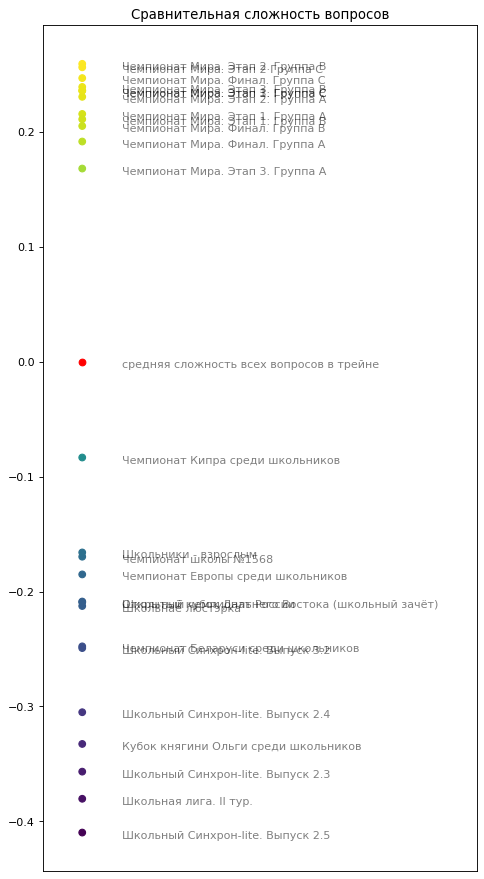

In [27]:
tourn_id_for_plot = tourn_list_school + tourn_list_world
x_for_plot = [0] * (len(tourn_list_to_compare))
y_for_plot = average_question_diff_to_compare
colors = y_for_plot

plt.figure(figsize=(7, 14), dpi=80)
plt.xlim([-0.1, 1])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.scatter(x_for_plot, y_for_plot, c=colors)
plt.scatter(0, average_diff_overall,c='red')
plt.text(x=0.1, y=average_diff_overall-0.005, s='средняя сложность всех вопросов в трейне', alpha=0.5)
plt.title('Сравнительная сложность вопросов')

for i in range(len(tourn_id_for_plot)):
    plt.text(x=x_for_plot[i]+0.1, y=y_for_plot[i]-0.005, s=data_tournaments[tourn_id_for_plot[i]]['name'], alpha=0.5)
    
plt.show()

Это хорошая картинка, примерно такую мы и надеялись получить. Теперь посмотрим на отдельные вопросы. Имя турнира и номер (нумерация с единицы, как в базе) приведем для топ-10.

In [28]:
# это техническая клетка чтобы искать по номеру вопроса турнир, откуда он взялся, и номер вопроса внутри турнира 
# номер вопроса внутри турнира будем возвращать с единицы! как в базе

questions_id_for_decode_tiled = []
for i in range(0, len(tourn_train)):
    tourn_number_tiled = [tourn_train[i]] * num_of_questions_in_tourns[i]
    questions_id_for_decode_tiled.extend(tourn_number_tiled)

    
def get_tourn_num_from_question_num(question_num):
    return int(questions_id_for_decode_tiled[question_num]) 

    
def get_question_num_in_tourn(question_num):
    return int(question_num - np.sum(
        num_of_questions_in_tourns[:tourn_train.index(questions_id_for_decode_tiled[question_num])])) + 1


In [29]:
top_size = 10

coef_questions = list(model.coef_[0][num_of_players:])
questions_num_sorted = np.flip(np.argsort(coef_questions))
questions_diff_sorted = np.flip(np.sort(coef_questions))

print("Топ вопросов по сложности: сложность/номер вопроса в турнире/название турнира")
for i in range(0, top_size):
    q_num = questions_num_sorted[i]
    print(questions_diff_sorted[i].round(3), get_question_num_in_tourn(q_num
                                                                     ), data_tournaments[get_tourn_num_from_question_num(
                                                                        q_num)]['name'])


print("\nСамые легкие вопросы: сложность/номер вопроса в турнире/название турнира")
for i in range(-1, -1-top_size, -1):
    q_num = questions_num_sorted[i]
    print(questions_diff_sorted[i].round(3), get_question_num_in_tourn(q_num
                                                                     ), data_tournaments[get_tourn_num_from_question_num(
                                                                        q_num)]['name'])


Топ вопросов по сложности: сложность/номер вопроса в турнире/название турнира
0.749 15 Чемпионат Мира. Финал. Группа А
0.742 14 Чемпионат Мира. Этап 2. Группа А
0.742 15 Чемпионат Мира. Этап 3. Группа А
0.699 5 Чемпионат Мира. Этап 1. Группа А
0.679 7 Чемпионат Мира. Этап 2. Группа А
0.669 24 Чемпионат Мира. Этап 3. Группа А
0.655 68 Чемпионат России
0.655 40 Чемпионат России
0.647 33 Чемпионат Санкт-Петербурга. Высшая лига
0.647 168 Чемпионат Санкт-Петербурга. Высшая лига

Самые легкие вопросы: сложность/номер вопроса в турнире/название турнира
-0.918 9 Открытый зимний чемпионат ТИУ
-0.905 43 Открытый чемпионат Белгородской области
-0.902 36 Кубок княгини Ольги среди школьников
-0.889 5 Школьный Синхрон-lite. Выпуск 2.5
-0.888 13 Кубок княгини Ольги среди школьников
-0.884 34 Школьный Синхрон-lite. Выпуск 2.4
-0.866 34 Открытый кубок УМЭД
-0.859 2 Большая перемена
-0.858 13 Студенческий чемпионат Калининградской области
-0.858 29 Студенческий чемпионат Калининградской области


Конкретные вопросы в базе я искала вручную и не очень преуспела. Отдельно меня удивило, что вопрос 9 в зимнем чемпионате ТИУ кажется сильно сложнее вопроса 10 там же. Это бы объяснилось тем, что я потеряла единицу при счете (например, не учла что в турнирах нумерация не с нуля), но вроде не теряла. Загадка... (на всякий случай, вопросы привожу) Или 9-ый не сложнее?

[Ссылка на турнир с упомянутыми вопросами: ](https://db.chgk.info/tour/wc19_u.1)

Вопрос 9:
Правитель из поэмы Шоты́ Руставе́ли, желая оградить дочь от опасностей и болезней, воздвиг ЕЁ. 
О происхождении материала поэт не пишет, однако известно, что и в Грузии, и в Аравии было хорошо развито скотоводство. 
Назовите ЕЁ двумя или тремя словами, два из которых начинаются на одну букву.

Ответ: безоа́ровая башня.

Зачёт: башня из безоа́ра

Вопрос 10:
На одном барельефе бог Ша́маш передает Хаммура́пи символы царской власти: жезл и магическое кольцо. 
    Герой фантастического романа Нила Стивенсона считает, что на самом деле Хаммурапи получил ИХ и потому смог 
    создать законы, управляющие обществом. Назовите ИХ точно.

Ответ: единица и ноль.

Зачёт: в любом порядке, в том числе цифрами. 

### 6. Топ игроков.

Теперь посмотрим статистику по игрокам.

In [30]:
# посчитаем, сколько вопросов сыграл каждый игрок
to_count_num_of_questions_played = [el[0] for el in X_for_enc]
values, counts = np.unique(to_count_num_of_questions_played, return_counts=True)
number_of_questions_played_by_player = {player_id : counts[np.where(values==player_id)][0] for player_id in players_id_for_decode}

In [31]:
num_of_players = len(enc.categories_[0])

def print_top_players(top_size, model):
    coef_players = list(model.coef_[0][0:num_of_players])

    top_players_strength = np.sort(coef_players)[0:top_size]
    top_players_num = np.argsort(coef_players)[0:top_size]


    print("\nСамые сильные игроки: сила / число сыгранных вопросов (из трейна) / ФИО")
    for i in range(0, top_size):
        player_id = players_id_for_decode[top_players_num[i]]
        number_of_questions_played = number_of_questions_played_by_player[player_id]
        print(-top_players_strength[i].round(3), number_of_questions_played, data_players[
            player_id]['surname'], data_players[player_id]['name'], data_players[player_id]['patronymic'])

In [32]:
print_top_players(10, best_model)


Самые сильные игроки: сила / число сыгранных вопросов (из трейна) / ФИО
0.657 2092 Руссо Максим Михайлович
0.637 2606 Брутер Александра Владимировна
0.632 3608 Семушин Иван Николаевич
0.631 45 Кудинов Дмитрий Сергеевич
0.624 36 Пилипенко Максим Игоревич
0.623 2942 Савченков Михаил Владимирович
0.612 4685 Сорожкин Артём Сергеевич
0.609 3535 Спешков Сергей Леонидович
0.601 1512 Мереминский Станислав Григорьевич
0.6 36 Петров Денис Борисович


"Лазутчиков-новичков" в топе 3 из 10 (и шесть из топ-30) --- подозреваю, что не так много, как должно быть, судя по описанию домашки. При этом в baseline, как в линейной, так и в логреге, топ весь занят новичками (см. ниже). Почему-то получается наоборот. Это мне не понятно. Даже если предположить, что мой EM-алгоритм - не ЕМ (там от итерации к итерации мало что меняется, и метрики, и топ игроков), а на самом деле baseline, то почему в бейзлайне, где эффект лишних людей в топе должен быть ниже, он сильно выше? Буду благодарна за любой комментарий.

In [33]:
print("Linear regression:")
print_top_players(10, lr)
print("\nLogistic regression:")
print_top_players(10, logreg)

Linear regression:

Самые сильные игроки: сила / число сыгранных вопросов (из трейна) / ФИО
0.612 36 Богданов Даниил Александрович
0.612 36 Балтруков Дмитрий Иванович
0.612 36 Власова Олеся Сергеевна
0.612 36 Логвинова Заряна Сергеевна
0.612 36 Тошматов Мехрубон Одилжоювич
0.612 36 Попова Анастасия Олеговна
0.612 36 Медведчук Михаил Владимирович
0.612 36 Богомазова Дана Романовна
0.612 36 Новикова Полина Сергеевна
0.612 36 Капитанова Екатерина Станиславовна

Logistic regression:

Самые сильные игроки: сила / число сыгранных вопросов (из трейна) / ФИО
3.378 72 Тишанинова Дарья Дмитриевна
3.378 72 Цыганенко Елизавета Вадимовна
3.309 36 Никифорова Дарья 
3.309 36 Васильев Антон 
3.309 36 Яковлева Анна 
3.309 36 Никитин Роман 
3.309 36 Алексеев Дмитрий 
3.309 36 Богданов Владислав 
3.309 36 Белолуцкая Софья 
3.272 72 Трепко Татьяна Александровна


Попробуем все же убрать лишних людей из топа. Поищем порог отсечения по количеству сыгранных вопросов.

In [34]:
def get_persona_non_grata_list(question_threshold):
    return [p_id for p_id in players_id_for_decode if number_of_questions_played_by_player[p_id] < question_threshold]

print("Total number of players is ", len(players_id_for_decode))
for q_threshold in [36, 37, 60, 100, 500, 1000]:
    non_grata_num = len(get_persona_non_grata_list(q_threshold))
    print("Number of players with less than %d questions played is %d (the rest is %d)" % (
        q_threshold, non_grata_num, len(players_id_for_decode) - non_grata_num)
         )

Total number of players is  53190
Number of players with less than 36 questions played is 1182 (the rest is 52008)
Number of players with less than 37 questions played is 18690 (the rest is 34500)
Number of players with less than 60 questions played is 21348 (the rest is 31842)
Number of players with less than 100 questions played is 29893 (the rest is 23297)
Number of players with less than 500 questions played is 45520 (the rest is 7670)
Number of players with less than 1000 questions played is 49400 (the rest is 3790)


То есть мы видим, что примерно 17 тысяч человек (из 53 тысяч) сыграли ровно один турнир на 36 вопросов. Поставим порог отсечения в 60 (то есть будем брать людей, сыгравших хотя бы два турнира, и при этом отсеем меньше половины участников).

Если просто игнорировать новичков, результаты членов их команд искажаются в лучшую сторону: если бывалый играл в команде из пяти новичков, то игнорируя новичков, мы автоматически припишем все успехи команды одному человеку. Поэтому, если мы хотим убрать из рассмотрения людей игравших мало, стоит не учитывать результаты всей команды, в которую новички входили. 

Еще вероятна проблема, что теперь выйдут в топ те, кто сыграл не один турнир, а, скажем, три --- из них два турнира вместе с совсем новичками и следовательно неучтенные. Посмотрим.

Удалим из рассмотрения команды с новичками и переобучим обычные линрегрессию, логрегрессию и модель из EM-алгоритма --- и выведем новый топ.

In [35]:
def get_data_for_enc_v2(list_of_tournaments, persona_non_grata_list):
    X_for_enc = np.empty((0,2), int)
    y_for_enc = np.array([])
    num_of_questions_already_played = 0
    to_stack_for_X = []
    to_stack_for_y = []
    counter_inconsistent = 0
    non_grata_teams_counter = 0
    tourn_counter = 0
    
    for idx_tourn in list_of_tournaments:
        num_of_current_questions = len([int(res) for res in data_results[idx_tourn][0]['mask'] if res=='0' or res=='1'])
        
        current_questions_idx = np.arange(
            num_of_questions_already_played, num_of_questions_already_played + num_of_current_questions)
        num_of_questions_already_played += num_of_current_questions
        
        idx_teams = 0
        while idx_teams < len(data_results[idx_tourn]):

            team_non_grata_flag = False
            
            y_current = np.array([int(res) for res in data_results[idx_tourn][idx_teams]['mask'] if res=='0' or res=='1'])
            team_players_idx = []
            for idx_team_members in range(0, len(data_results[idx_tourn][idx_teams]['teamMembers'])):
                player_id = int(data_results[idx_tourn][idx_teams]['teamMembers'][idx_team_members]['player']['id'])
                
                if player_id in persona_non_grata_list:
                    team_non_grata_flag = True
                    
                team_players_idx.append(player_id) 
                
            if team_non_grata_flag == False:
                player_question_pairs = np.transpose([np.repeat(team_players_idx, len(current_questions_idx)), 
                                                      np.tile(current_questions_idx, len(team_players_idx))])
                y_for_current_team = np.tile(y_current, len(team_players_idx)).reshape(-1, 1)
            else:
                non_grata_teams_counter += 1
            
              
            to_stack_for_X.append(player_question_pairs)            
            to_stack_for_y.append(y_for_current_team)
        
            idx_teams += 1
            
        num_of_questions_in_tourns.append(num_of_current_questions)
        tourn_counter += 1
        if tourn_counter % 100 == 0:
            print("Handling tournament number ", tourn_counter)

    X_for_enc = np.vstack((to_stack_for_X))
    y_for_enc = np.vstack((to_stack_for_y))
    print("X_for_enc.shape = ", X_for_enc.shape)
    print("y_for_enc.shape = ", y_for_enc.shape)
            
        
    print(non_grata_teams_counter, "times teams were excluded")
    #print(np.sum(y_for_enc, axis=0))
    
    return X_for_enc, y_for_enc, num_of_questions_in_tourns

In [36]:
persona_non_grata_list = get_persona_non_grata_list(60)

In [37]:
%%time

X_for_enc_no_newbies, y_for_enc_no_newbies, num_of_questions_in_tourns = get_data_for_enc_v2(
    tourn_train, persona_non_grata_list
)

Handling tournament number  100
Handling tournament number  200
Handling tournament number  300
Handling tournament number  400
Handling tournament number  500
Handling tournament number  600
X_for_enc.shape =  (14555056, 2)
y_for_enc.shape =  (14555056, 1)
9246 times teams were excluded
Wall time: 14min 10s


In [38]:
%%time

enc_no_newbies = OneHotEncoder(dtype='int32')
enc_no_newbies.fit(X_for_enc_no_newbies)
X_train_no_newbies = enc_no_newbies.transform(X_for_enc_no_newbies)#.toarray()
X_train_no_newbies

Wall time: 3.62 s


<14555056x59525 sparse matrix of type '<class 'numpy.int32'>'
	with 29110112 stored elements in Compressed Sparse Row format>

In [39]:
# подготовка данных

num_of_players = len(enc_no_newbies.categories_[0])
players_id_for_decode = enc_no_newbies.categories_[0]

to_count_num_of_questions_played = [el[0] for el in X_for_enc_no_newbies]
values, counts = np.unique(to_count_num_of_questions_played, return_counts=True)
number_of_questions_played_by_player = {player_id : counts[np.where(values==player_id)][0] for player_id in players_id_for_decode}


In [40]:
%%time

lr_no_newbies = LinearRegression()
lr_no_newbies.fit(X_train_no_newbies, y_for_enc_no_newbies)

Wall time: 1min 9s


LinearRegression()

In [41]:
lr_no_newbies.coef_

array([[ 0.03713098,  0.19568361,  0.12138529, ...,  0.59116726,
         0.0622417 , -0.30965908]])

In [42]:
print_top_players(10, lr_no_newbies)


Самые сильные игроки: сила / число сыгранных вопросов (из трейна) / ФИО
0.642 36 Коротков Илья Николаевич
0.642 36 Пилясова Дарья Алексеевна
0.627 72 Кучумова Карина Викторовна
0.627 72 Степанова Татьяна Алексеевна
0.627 72 Садовский Николай Сергеевич
0.627 72 Галухин Кирилл Сергеевич
0.627 72 Семёнов Денис Васильевич
0.599 72 Никифорова Елизавета Алексеевна
0.599 72 Минчуна Виктория Викторовна
0.599 72 Кишеев Егор Геннадьевич


In [43]:
%%time

logreg_no_newbies = LogisticRegression(solver='saga')
logreg_no_newbies.fit(X_train_no_newbies, y_for_enc_no_newbies.ravel())

Wall time: 3min 51s


LogisticRegression(solver='saga')

In [44]:
print_top_players(10, logreg_no_newbies)


Самые сильные игроки: сила / число сыгранных вопросов (из трейна) / ФИО
5.022 288 Махмуджонова Рухсора Маъсуджон кизи
4.625 180 Трепко Татьяна Александровна
4.544 2088 Добросельская Валерия Викторовна
4.544 2088 Бердникова Арина Анатольевна
4.544 2088 Плаксина Светлана Игоревна
4.544 2088 Саукова Дарья Евгеньевна
4.503 180 Курочкина Анастасия Петровна
4.398 324 Хазраткулов Рустам Жахонгирович
4.295 360 Самандаров Элбек Санджарович
4.295 360 Тамазов Рамис Шамильевич


Видно, что попытка избавиться от новичков в топе для линейной регрессии провалилась. Для логистической регрессии дело как будто бы обстоит лучше --- появляются люди, которые много играли, --- но на самом деле по официальному рейтингу они все еще не занимают сколько-нибудь значительного места. Посмотрим теперь, что поменяется в (и так вполне приличном) топе для нашей ЕМ-модели.

In [45]:
%%time

anti_y_no_newbies = 1 - y_for_enc_no_newbies
expectation_anti_no_newbies = anti_y_no_newbies

iterations = 5

metrics_list_pearson = []
metrics_list_kendall = []

for i in range(0, iterations):
    print("Iteration ", i)
    
    model_no_newbies = LinearRegression()
    model_no_newbies.fit(X_train_no_newbies, expectation_anti_no_newbies)        ## M - шаг
    
    pearson, kendall = calculate_correlations(tourn_test, model)
    metrics_list_pearson.append(-pearson)
    metrics_list_kendall.append(-kendall)
    
    expectation_anti_no_newbies = model_no_newbies.predict(X_train_no_newbies)   ## E - шаг
    
best_model_no_newbies = model_no_newbies

Iteration  0
Iteration  1
Iteration  2
Iteration  3
Iteration  4
Wall time: 6min 45s


In [46]:
print_top_players(10, best_model_no_newbies)


Самые сильные игроки: сила / число сыгранных вопросов (из трейна) / ФИО
0.589 45 Григорьев Михаил Сергеевич
0.579 2092 Руссо Максим Михайлович
0.559 2606 Брутер Александра Владимировна
0.554 3608 Семушин Иван Николаевич
0.545 2942 Савченков Михаил Владимирович
0.533 3499 Спешков Сергей Леонидович
0.533 4724 Сорожкин Артём Сергеевич
0.523 1512 Мереминский Станислав Григорьевич
0.513 1365 Левандовский Михаил Ильич
0.511 454 Царёв Михаил Сергеевич


Теперь в топ-10 игроков вместо трех лазутчиков всего двое (точнее даже полтора --- т.к. Царев Михаил Сергеевич уже не ноунейм, а вполне себе игрок с местом 1295-1296 в официальном рейтинге) и сам топ чуть перемешался. Но в целом рейтинг этой модели и до улучшения, и после весьма похож на настоящий.